# Federated Learning for Image Classification

In this tutorial, we use the classic MNIST training example to introduce the
Federated Learning (FL) component of TFF - a set of higher-level interfaces that
can be used to perform common types of federated learning tasks, such as
federated training, against user-supplied models implemented in TensorFlow.

This tutorial, and the Federated Learning API, are intended primarly for users
who will want to plug their own TensorFlow models into TFF, treating the latter
mostly as a black box. For a more in-depth understanding of TFF and how to
implement your own federated learning algorithms, consider also reviewing as a
follow-up the tutorial on lower-level interfaces -
[Custom Federated Algorithms with the Federated Core API](custom_federated_algorithms.ipynb).

## Before we start

Before we start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
from six.moves import range
import numpy as np
import tensorflow as tf

from tensorflow_federated import python as tff

nest = tf.contrib.framework.nest

np.random.seed(0)

tf.enable_eager_execution()
tf.enable_resource_variables()
tf.compat.v1.enable_v2_behavior()

tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

## Preparing the input data

Let's start with the data. Federated Learning requires a federated data set,
i.e., a collection of data from multipe users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a collection of
data obtained from real users that reflects their individual handwriting styles.

Here's how we can load it.

In [0]:
#@test {"output": "ignore"}
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to enumerate the set
of users, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations.

In [3]:
len(emnist_train.client_ids)

3383

In [4]:
emnist_train.output_types, emnist_train.output_shapes

(OrderedDict([(u'label', tf.int32), (u'pixels', tf.float32)]),
 OrderedDict([(u'label', TensorShape([])), (u'pixels', TensorShape([28, 28]))]))

In [5]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

5

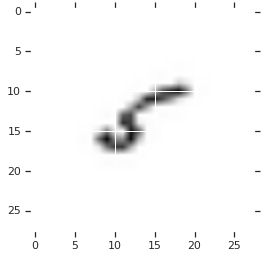

In [6]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt

plt.imshow(example_element['pixels'].numpy(), cmap='gray')

It is customary for data to require some preprocessing before it is fed into the
model. Since the data comes in the form of `tf.data.Dataset`s, you will
implement such preprocessing as operations on such structures. To illustrate
this, here's a simple preprocessing function that flattens the `28x28` images
into `784`-element arrays, organizes them into batches, and renames the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 20

def preprocess(dataset):
  def element_fn(element):
    return collections.OrderedDict([
      ('x', tf.reshape(element['pixels'], [-1])), ('y', element['label'])])
  return dataset.repeat(NUM_EPOCHS).map(element_fn).batch(BATCH_SIZE)

Let's verify this worked.

In [8]:
#@test {"output": "ignore"}
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

sample_batch

OrderedDict([('x', array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]], dtype=float32)), ('y', array([5, 8, 9, 3, 7, 4, 2, 9, 3, 5, 4, 1, 4, 1, 2, 2, 3, 7, 1, 0], dtype=int32))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is, simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as an eager `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [0]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on
[federated model averaging](https://arxiv.org/abs/1602.05629), achieving
convergence in a system with randomly sampled subsets of clients in each round
can take a while, and it would be impractical to have to run hundreds of rounds
in this interactive tutorial.

What we'll do instead is, therefore, to sample the set of clients once, and
reuse the same set across rounds to speed up convergence. We leave it as an
exercise for the reader to modify this colab to simulate random sampling - it is
fairly easy to do (once you do, keep in mind that getting the model to converge
may take a while).

In [10]:
#@test {"output": "ignore"}
NUM_CLIENTS = 3

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

len(federated_train_data), federated_train_data[0]

(3,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None,))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

## Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [0]:
def create_compiled_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(784,)),
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros')])
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.SGD(0.1),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.Model` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a compiled Keras model
like the one we've just defined above, you can have TFF wrap it for you by
invoking `tff.learning.from_compiled_keras_model`, passing the model and a
sample data batch as arguments, as shown below.

In [0]:
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a federated averaging algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms.ipynb)).

In [0]:
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

What did just happen? TFF has constructed a pair of *federated computations* and
packaged them into a standardized iterator-like structure
`tff.utils.IterativeProcess` in which these computations are available as a pair
of properties `initialize` and `next`.

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms (you can find more about this in
the [custom algorithms](custom_federated_algorithms.ipynb) tutorial). In this
case, the two computations generated and packed into `iterative_process`
implement [federated model averaging](https://arxiv.org/abs/1602.05629).

In one of the upcoming releases of the framework, we'll enable you to deploy
such computations for execution in real environments, such as on groups of
`Android` devices. In this tutorial, we'll execute federated computations in a
simple interpreted environment in a simulator, inside this notebook. To execute
a computation in a simulator, you simply invoke it like a Python function, as we
will demonstrate shortly. This default interpreted environment is not designed
for high performance, but it will suffice for this tutorial.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
federated averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [14]:
#@test {"output": "ignore"}
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `model` (the initial model
parameters for MNIST that will be distributed to all devices), and
`optimizer_state` (additional information maintained by the server, such as the
number of rounds to use for hypermarameter schedules, etc.).

Let's invoke the `initialize` computation to construct the server state.

In [0]:
state = iterative_process.initialize()

The second of the pair of federated computations, `next`, represents a single
round of federated averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [0]:
#@test {"timeout": 600}
state, metrics = iterative_process.next(state, federated_train_data)

In [17]:
#@test {"output": "ignore"}
str(metrics)

'<sparse_categorical_accuracy=0.121818,loss=26.3481>'

Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [18]:
#@test {"skip": true}
for _ in range(10):
  state, metrics = iterative_process.next(state, federated_train_data)
  print (metrics)

<sparse_categorical_accuracy=0.137818,loss=25.5942>
<sparse_categorical_accuracy=0.165455,loss=22.5511>
<sparse_categorical_accuracy=0.174545,loss=21.39>
<sparse_categorical_accuracy=0.261818,loss=15.0954>
<sparse_categorical_accuracy=0.309818,loss=12.7362>
<sparse_categorical_accuracy=0.373091,loss=10.2267>
<sparse_categorical_accuracy=0.408,loss=7.69943>
<sparse_categorical_accuracy=0.451636,loss=6.94983>
<sparse_categorical_accuracy=0.552,loss=4.94758>
<sparse_categorical_accuracy=0.628364,loss=3.67724>


## Customizing the model implementation

While handing your Keras model to `tff.learning.from_keras_model` or
`tff.learning.from_compiled_keras_model` and letting TFF automatically wrap it
for use in federated learning may be a good place to start, in many cases you
will want to have more explicit control over the process and customize it for
your scenario, so let's do it all over again from scratch.

### Defining model variables, forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with.
In order to make the following code more legible, let's define a data structure
to represent the entire set. This will include variables such as `weights` and
`bias` that we will train, as well as variables that will hold various
cumulative statistics and counters we will update during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [0]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we
represent all statistics as `tf.float32`, as that will eliminate the need for
type conversions at a later stage. Wrapping variable initializers as lambdas is
a requirement imposed by
[resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [0]:
def create_mnist_variables():
  return MnistVariables(
      weights = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples = tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum = tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum = tf.Variable(0.0, name='accuracy_sum', trainable=False))

With the variables for model parameters and cumulative statistics in place, we
can now define the forward pass method that computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data, as
follows.

In [0]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  loss = -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(batch['y'], 10) * tf.log(y), reduction_indices=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, batch['y']), tf.float32))

  num_examples = tf.to_float(tf.size(batch['y']))

  tf.assign_add(variables.num_examples, num_examples)
  tf.assign_add(variables.loss_sum, loss * num_examples)
  tf.assign_add(variables.accuracy_sum, accuracy * num_examples)

  return loss, predictions

With the single-batch forward pass defined, TFF has enough information to put
together a training loop that processes the on-device data for a single user,
but we may want to still control the manner in which we translate the cumulative
statistics accumulated in the course of training into a set of metrics to be
exported by the device, so let's write another helper function to perform this
translation.

We're just going to export the average `loss` and `accuracy`, as well as the
`num_examples`; we'll need the latter to correctly weigh the contributions from
different users when computing the global statistics at the server.

In [0]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict([
      ('num_examples', variables.num_examples),
      ('loss', variables.loss_sum / variables.num_examples),
      ('accuracy', variables.accuracy_sum / variables.num_examples)
    ])

Finally, we need to determine how to aggregate the local metrics emitted by each
device. This is the only part of the code that isn't written in pure TensorFlow
and Python - it's a *federated computation* expressed in TFF. If you'd like to
dig deeper, skim over the [custom algorithms](custom_federated_algorithms.ipynb)
tutorial, but in most applications, you won't really need to; variants of the
pattern show below should suffice.

Typically at this point, you would average metrics and sum up counters, as is
the case in our example - we simply apply `tff.federated_sum` to metrics you
want to sum and `tff.federated_average` to those you want to average, return the
dictionary of what you wish to report globally, and decorate your function as
`tff.federated_computation`.

In [0]:
@tff.federated_computation
def aggregate_local_mnist_metrics(metrics):
  return {
      'num_examples': tff.federated_sum(metrics.num_examples),
      'loss': tff.federated_average(metrics.loss, metrics.num_examples),
      'accuracy': tff.federated_average(metrics.accuracy, metrics.num_examples)
  }

### Constructing an instance of `tff.learning.Model`

With all of the above in place, we are ready to construct a model representation
for use with TFF similar to one that's generated for you when you let TFF ingest
a Keras model.

In [0]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict([('x', tf.TensorSpec([None, 784],
                                                        tf.float32)),
                                    ('y', tf.TensorSpec([None], tf.int32))])

  @tf.contrib.eager.function(autograph=False)
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    return tff.learning.BatchOutput(loss=loss, predictions=predictions)

  @tf.contrib.eager.function(autograph=False)
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_local_mnist_metrics

As you can see, the abstract methods and properties defined by
`tff.learning.Model` correspond closely to the code snippets that introduce the
variables, define the loss and statistics that we introduced in the preceding
section.

Here are a few points worth highlighting:

*   All state that your model will use must be captured as TensorFlow variables,
    as TFF does not use Python at runtime (remember your code should be written
    such that it can be deployed to mobile devices; see the
    [custom algorithms](custom_federated_algorithms.ipynb) tutorial for a more
    in-depth commentary on the reasons). The variables should always be created
    in the constructor.
*   Your model should describe what form of data it accepts (`input_spec`), as
    in general, TFF is a stronly-typed environment and wants to determine type
    signatures for all components. Declaring the format of your model's input is
    an essential part of it.
*   Although technically not required, we recommend wrapping all TensorFlow
    logic (forward pass, metric calculations) as `tf.contrib.eager.function`s.

While the above is technically sufficient, and TFF can take over from here,
there's one more optional part you may want to customize, and that's defining
the optimizer and how it's applied to the data to perform a single step of
training.

While TFF can do it for you, it's common to take control over this step as well,
e.g., as follows.

In [0]:
class MnistTrainableModel(MnistModel, tff.learning.TrainableModel):

  @tf.contrib.eager.defun(autograph=False)
  def train_on_batch(self, batch):
    output = self.forward_pass(batch)
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    optimizer.minimize(output.loss, var_list=self.trainable_variables)
    return output

### Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've
seen already - just replace the model constructor with the constructor of our
new model class, and use the two federated computations in the iterative process
you created to cycle through training rounds.

In [0]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistTrainableModel)

In [0]:
state = iterative_process.initialize()

In [0]:
#@test {"timeout": 600}
state, metrics = iterative_process.next(state, federated_train_data)

In [29]:
#@test {"output": "ignore"}
str(metrics)

'<accuracy=0.116364,loss=26.9393,num_examples=2750.0>'

In [30]:
#@test {"skip": true}
for _ in range(10):
  state, metrics = iterative_process.next(state, federated_train_data)
  print (metrics)

<accuracy=0.127636,loss=25.7923,num_examples=2750.0>
<accuracy=0.16,loss=nan,num_examples=2750.0>
<accuracy=0.215273,loss=18.5418,num_examples=2750.0>
<accuracy=0.228,loss=17.0847,num_examples=2750.0>
<accuracy=0.265091,loss=14.5335,num_examples=2750.0>
<accuracy=0.377455,loss=9.18476,num_examples=2750.0>
<accuracy=0.408364,loss=7.80384,num_examples=2750.0>
<accuracy=0.487273,loss=6.87648,num_examples=2750.0>
<accuracy=0.519636,loss=6.03614,num_examples=2750.0>
<accuracy=0.609455,loss=4.19763,num_examples=2750.0>


## Evaluation

All of our experiments so far focused on the same set of training data, which of
course brings potential concerns about overfitting. Now, in a real systems,
those concerns would be mitigated by the presence of millions of users, only a
tiny fraction of whom participate in each round of training, but in a
simulation, we need to be more careful, especially that we are reusing the same
users for demonstration purposes.

To perform evaluation, you can construct another *federated computation*
designed for just this purpose, as follows, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike in our earlier example, where we've
used `MnistTrainableModel`, it suffices to pass the `MnistModel`. Evaluation
doesn't perform gradient descent, and there's no need to construct optimizers.
Your model class just needs to support the `tff.learning.Model.forward_pass`
method, and the associated ones for reporting and aggregating per-client
metrics.

In [0]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

You can inspect the abstract type signature of the evaluation function as follows.

In [32]:
str(evaluation.type_signature)

'(<<trainable=<weights=float32[784,10],bias=float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?]>*}@CLIENTS> -> <accuracy=float32@SERVER,loss=float32@SERVER,num_examples=float32@SERVER>)'

No need to be concerned about the details at this point, just be aware that it
takes the following general form, similar to `tff.utils.IterativeProcess.next`
but with two important differences. First, we are not returning server state,
since evaluation doesn't modify the model or any other aspect of state - you can
think of it as stateless. Second, evaluation only needs the model, and doesn't
require any other part of server state that might be associated with training,
such as optimizer variables.

```
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS
```

Let's invoke evaluation on the latest state we arrived at during training. In
order to extract the latest trained model from the server state, you simply
access the `.model` member, as follows.

In [0]:
#@test {"output": "ignore"}
train_metrics = evaluation(state.model, federated_train_data)

Here's what we get. Note the numbers look marginally bettre than what was
reported by the last round of training above. By convention, the training
metrics reported by the iterative training process generally reflect the
performance of the model at the beginning of the training round, so the
evaluation metrics will always be one step ahead.

In [34]:
#@test {"output": "ignore"}
# TODO(b/124513803): Remove ignore after investigating the variability that
# seems to occur in the presubmit environment, potentially related to the
# TensorFlow version, and resubmit with the stable numbers.
str(train_metrics)

'<accuracy=0.585455,loss=2.88178,num_examples=2750.0>'

Now, let's compile a test sample of federated data and rerun evaluation on the
test data. The data will come from the same sample of real users, but from a
distinct held-out data set.

In [35]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(3,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None,))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [0]:
#@test {"output": "ignore"}
# TODO(b/124513803): Ditto, remove ignore and resubmit after fixing variability.
test_metrics = evaluation(state.model, federated_test_data)

In [37]:
#@test {"output": "ignore"}
str(test_metrics)

'<accuracy=0.606061,loss=2.70806,num_examples=330.0>'

This concludes the tutorial. As noted above, we encourage you to play with the
parameters (e.g., batch sizes, number of users, epochs, learning ratres, etc.),
and to modify the code above to simulate training on random samples of users in
each round, and to explore other tutorials we've developed.